### Imports

In [1]:
import pandas as pd
import numpy as np
import torch

### Load sequence data from cryptic seq experiment

In [132]:
# Parameters
BINS = 2
SEQUENCE = 'seq'
VALUE = 'count'

# Load data from cryptic seq experiment
sites_xl = pd.ExcelFile('./data/TB000208a.outputs.xlsx')
sites_xl.sheet_names
training_sheets = ['GT-Rep1-N7_S1','GT-Rep2-N7_S2','GT-Rep3-N7_S3']
sheets = []
for name in training_sheets:
    sheets.append(sites_xl.parse(name))
sites = pd.concat(sheets).reset_index()

# Only take canonical dinucleotide insertions
sites = sites[sites['genome_dinucleotide'] == sites['donor'].str.slice(5,7)]

# Average count at identical sites
sites = sites.groupby(['seq'], as_index=False).sum(numeric_only=False)
sites[VALUE] = np.log(sites[VALUE])

# Bin the counts into N bins
sites[VALUE], bins = pd.cut(sites[VALUE], BINS, labels=False, retbins=True)

# Compute class frequencies for weighting
class_sample_count = np.array([len(np.where(sites[VALUE] == c)[0]) for c in np.unique(sites[VALUE])])

In [133]:
# Split into left and right
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
reverse_complement = lambda x: "".join(complement.get(base, base) for base in reversed(x))

left = sites[SEQUENCE].str.slice(0,22)
left_rc = left.apply(reverse_complement)
right = sites[SEQUENCE].str.slice(24,)
right_rc = right.apply(reverse_complement)

sites['left'] = left
sites['right'] = right_rc

combined_sites = pd.concat([pd.DataFrame({"seq": sites[key], "value": sites[VALUE]}) for key in ['left', 'right']]).reset_index()

# Use symmetric sites as data input
sites = combined_sites

In [134]:
import genome_utils
import genomepy
from sklearn.preprocessing import StandardScaler

genomic_reference_file = '../data/references/hg38.fa'

# Extract cryptic sites
hits = sites[SEQUENCE]
hit_count = len(hits)
hits_labels = sites['value']

# Length of a cryptic site
seq_length = len(hits[0])

# Generate random decoy sequences
genome = genomepy.genome.Genome(genomic_reference_file)
samples = genome.get_random_sequences(n=hit_count, length=seq_length-1, max_n=0)
decoys = pd.Series(list(map(lambda row: genome.get_seq(*row).seq.upper(), samples)))
decoys_labels = np.zeros(len(decoys))

# Concatenate hits and decoys
#sequences = np.hstack([hits, decoys])
#labels = np.hstack([hits_labels, decoys_labels])

# Positive data only
sequences = hits.values
labels = hits_labels.values

# Set dinucleotide to NN in both hits and decoys
#dn_start = int(seq_length/2)
#hits = hits.apply(lambda seq: seq[:dn_start-1] + 'NN' + seq[dn_start+1:])

In [154]:
from models import mlp
from datasets import one_hot

vocab_size = 5
hidden_size = 1024
n_hidden = 2
train_test_split = 0.8

dataset = one_hot.Dataset(sequences, labels, vocab_size=vocab_size, output_size=BINS)

# Sample weights based on label and class frequency
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])
samples_weight = torch.from_numpy(samples_weight)

# Test and train data split
train_size = int(train_test_split*len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Weighted random sampler for upsampling minority class
train_sample_weights = samples_weight[train_dataset.indices]
sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8)

# Build model
model = mlp.Model(input_size=seq_length*vocab_size, hidden_size=hidden_size, output_size=BINS, n_hidden=n_hidden, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [155]:
from sklearn.metrics import mean_squared_error, accuracy_score

epochs = 10
loss_fn = torch.nn.BCEWithLogitsLoss()

# training loop
for epoch in range(epochs):
    train_loss = 0.0
    train_preds, train_targets = [], []

    # Training Phase
    for i, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)

        # Convert output probabilities to predicted class
        preds = output.float()
        train_preds.extend(preds)
        train_targets.extend(target)

        loss = loss_fn(output, target.float())
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_error = accuracy_score(torch.argmax(torch.stack(train_targets), 1), torch.argmax(torch.stack(train_preds), 1))

    print(f"Epoch {epoch}/{epochs}")
    print(f"-------------")
    print(f"Train loss: {train_loss/len(train_dataloader)}")
    print(f"Train accuracy: {train_error}")

    val_loss = 0.0
    val_preds, val_targets = [], []

    # Validation Phase
    with torch.no_grad():
        for i, (data, target) in enumerate(val_dataloader):
            output = model(data)

            # Convert output probabilities to predicted class
            preds = output.float()
            val_preds.extend(preds)
            val_targets.extend(target)

            loss = loss_fn(output, target.float())
            val_loss += loss.item()

        val_error = accuracy_score(torch.argmax(torch.stack(val_targets), 1), torch.argmax(torch.stack(val_preds), 1))

    print(f"Val loss: {val_loss/len(val_dataloader)}")
    print(f"Val accuracy: {val_error}")
    print(f"-------------\n")

Epoch 0/10
-------------
Train loss: 0.4736319305555807
Train accuracy: 0.7717420390687717
Val loss: 0.4761919917758931
Val accuracy: 0.756532141283133
-------------

Epoch 1/10
-------------
Train loss: 0.3021833679382109
Train accuracy: 0.8730186214169907
Val loss: 0.3938070429711003
Val accuracy: 0.85651325316376
-------------

Epoch 2/10
-------------
Train loss: 0.22361921375450194
Train accuracy: 0.9110170158510287
Val loss: 0.4696190122670396
Val accuracy: 0.85651325316376
-------------

Epoch 3/10
-------------
Train loss: 0.17443364747454768
Train accuracy: 0.9319523367281084
Val loss: 0.4154841466612931
Val accuracy: 0.9063149279103444
-------------

Epoch 4/10
-------------
Train loss: 0.14624788479925208
Train accuracy: 0.9442616757701208
Val loss: 0.48684790693992863
Val accuracy: 0.8891267392809923
-------------

Epoch 5/10
-------------
Train loss: 0.12840466727169958
Train accuracy: 0.9529978435045412
Val loss: 0.5419871926761328
Val accuracy: 0.9005855317005603
-------

### Analysis

In [156]:
from matplotlib import pyplot as plt

# Iterate over the DataLoader and make predictions
val_inputs = []
val_targets = []
val_preds = []
with torch.no_grad():
    for i, (data, target) in enumerate(val_dataloader):
        output = model(data)

        # Convert output probabilities to predicted class
        preds = output.float()

        # Save prediction data
        val_inputs.extend(data.tolist())
        val_preds.extend(preds)
        val_targets.extend(target)

# Translate inputs
trans_dict = {0:'A',1:'T',2:'C',3:'G',4:'N'}
translate_func = lambda x: ''.join([trans_dict[y] for y in x])

inputs = np.argmax(val_inputs, axis=2)
inputs = [translate_func(x) for x in inputs]

# Argmax targets and predictions
val_targets = torch.argmax(torch.stack(val_targets), 1)
val_preds = torch.argmax(torch.stack(val_preds), 1)

predictions = pd.DataFrame({"seq":inputs, "targets":val_targets, "outputs": val_preds})

array([[<Axes: title={'center': 'targets'}>,
        <Axes: title={'center': 'outputs'}>]], dtype=object)

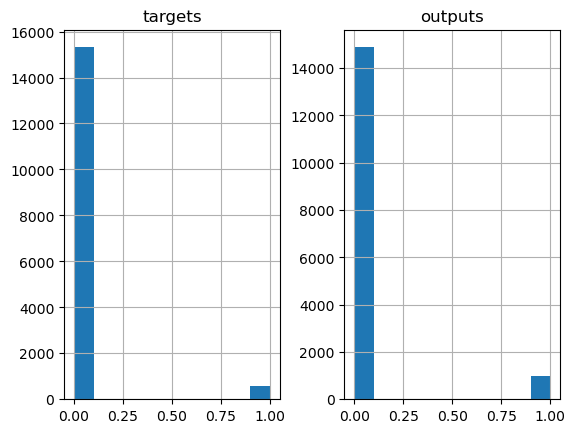

In [158]:
predictions.hist()

In [157]:
for seq in predictions[predictions['targets'] == 1]['seq']:
    print(seq)

GAGGATTGCTTGAACCTAGGAG
TGAATGTTTCTAGACAAAAGTG
AATGGTGGTTATCACAACGGCA
TGTTCAGAACCTCACCATTGAG
TGCATGGGTTGTGGCAGCGGAA
CCGCCTGGCTTCACCCACAGCC
GGTTGGTTTTGCTGTCTCAGGG
CCCCCTTTTTTATACATCTGAT
TTCCTTAGCTTCCCCAGCTGGA
AAAACAATTTTTAATAATAGAG
ACAGCAGACAGCAACAACAGCA
TACGTGATTTCTGAGCACTGAA
CCTTTTACTCTTCACAACGGAG
ACAGACTTGCTTTCACATGGAG
CTTTGAAGCCTTGACTACAGAG
AGTTGCCATCCCCTCAATGGAG
GAACATTTCCATCACCACAGAA
CAGCTTGCTCTTGATAACTGCG
AGAAAGTTTGTTTCCTACAGAG
TTTATGTATTTCTAGATTAGAG
CACTTGAATCCAGGCGACAGAG
AGTCAGCTTTCTGTCAACTGCA
CCTGCAATCTTAGCCAACAGTG
TAATTTTCCTTACGCAACGGTA
GGCTGTGGTTTGCACAGCTGAT
CACTTGAATCTGGGAGGCGGAG
GCAATTCATTTCTGCAATTGCT
TGGGGTCGCTTCACCAGCAGAA
GAAGGTGCTTCCGGCCACAGAG
TGGCATGATCTCAGTCACTGCA
CCCCGGTTTTCTGTCACTTGCA
TAGAAAATTTTCTTCCACAGCA
GTAGGTGATCTAGGCAATGGGA
ATCAGTGGTTCCCACCACAGGG
TCATTGAGTCTCTACTGCTGAG
TACTATATTCTAGACTGCTGCT
CCTATTTACTTTCACATCTGCA
GCCTATTTTGCTTACTGCTGCA
ACATTTCACTTCAGCCACTGAG
CAAGTTTTTGTCTCCAGCAGAG
CCTGGAAATGTCAACAATGGTT
GGCACGATCTTGGCTAACTGCA
GGAAGAAATCATAATAACGGAG
GCCAAGTTTGT